# Setup

In [1]:
!pip install ohsome

  Using cached pip-21.0.1-py3-none-any.whl (1.5 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# Variables

In [2]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ohsome import OhsomeClient
sns.set_theme(style="darkgrid")

/home/napo/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
if not os.path.exists('data'):
    os.makedirs('data')

In [4]:
client = OhsomeClient()

## bounding boxes

In [5]:
codogno=[9.60205,45.20284,9.78676,45.13071]
vo=[11.56277,45.36397,11.74747,45.29204]

### geojson italy

In [6]:
italy_geojson="https://raw.githubusercontent.com/AshKyd/geojson-regions/master/countries/10m/ITA.geojson"
italy_borders = gpd.read_file(italy_geojson)

### Codogno
population: 15.465<br/>
surface: 20 km²


In [7]:
# aggregation for each day (1D)
period = "2020-02-15/2020-05-15/P1D"
tags = "building=*"

In [8]:
response_codogno_buildings = client.elements.count.post(bboxes=codogno, time=period, filter=tags).as_dataframe()

2021-03-29 17:23:08,126     utils   INFO:  NumExpr defaulting to 4 threads.


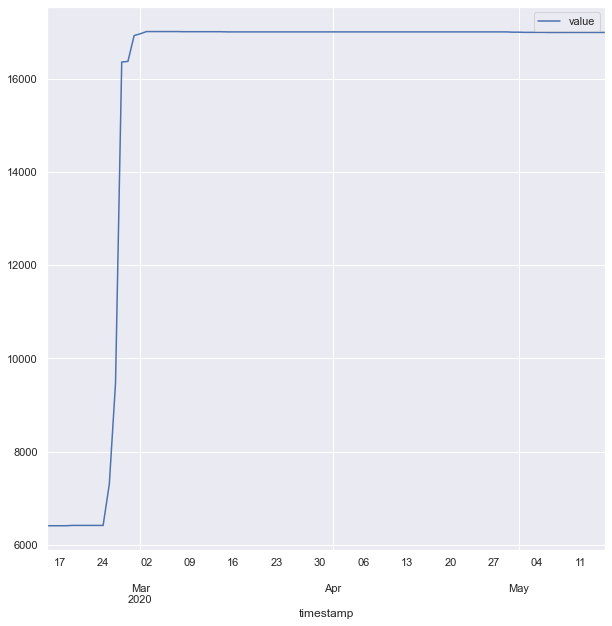

In [9]:
response_codogno_buildings.plot(figsize=(10,10))
plt.show()

In [10]:
response_codogno_buildings.to_csv("data" + os.sep + "codogno_buildings.csv")

### Vo'
population: 3.286<br/>
surface:  20,4 km²

In [11]:
bboxes = vo
time = "2020-02-15/2020-03-15/P1D"
flter = "building=*" # and type:way"

In [12]:
response = client.elements.count.post(bboxes=bboxes, time=time, filter=flter)
response_vo_buildings = response.as_dataframe()

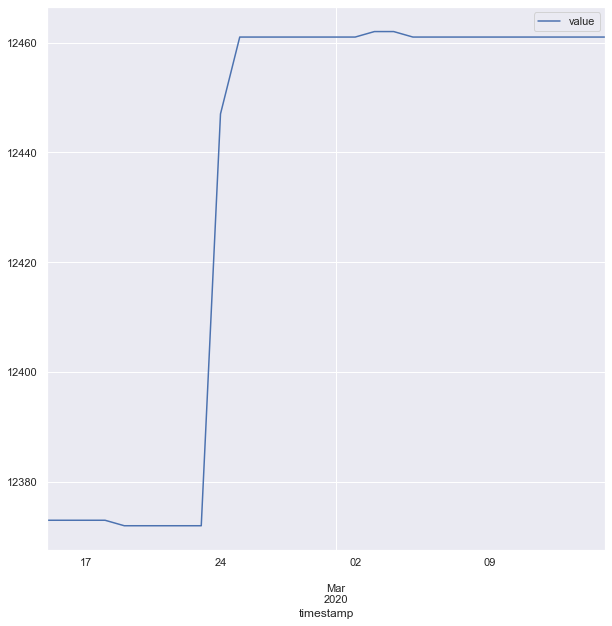

In [13]:
response_vo_buildings.plot(figsize=(10,10))
plt.show()

In [14]:
response_vo_buildings.to_csv("vo_buildings.csv")

# Pharmacy in Italy
monthly growth 

In [15]:
time = "2020-01-01/2020-12-31/P1M"
flter = "amenity=pharmacy" 

In [16]:
bpolys = gpd.read_file(italy_geojson)

In [17]:
pharmacy = client.elements.count.groupByBoundary.post(bpolys=bpolys, filter="amenity=pharmacy",time=time)

In [18]:
pharmacy_df = pharmacy.as_dataframe()

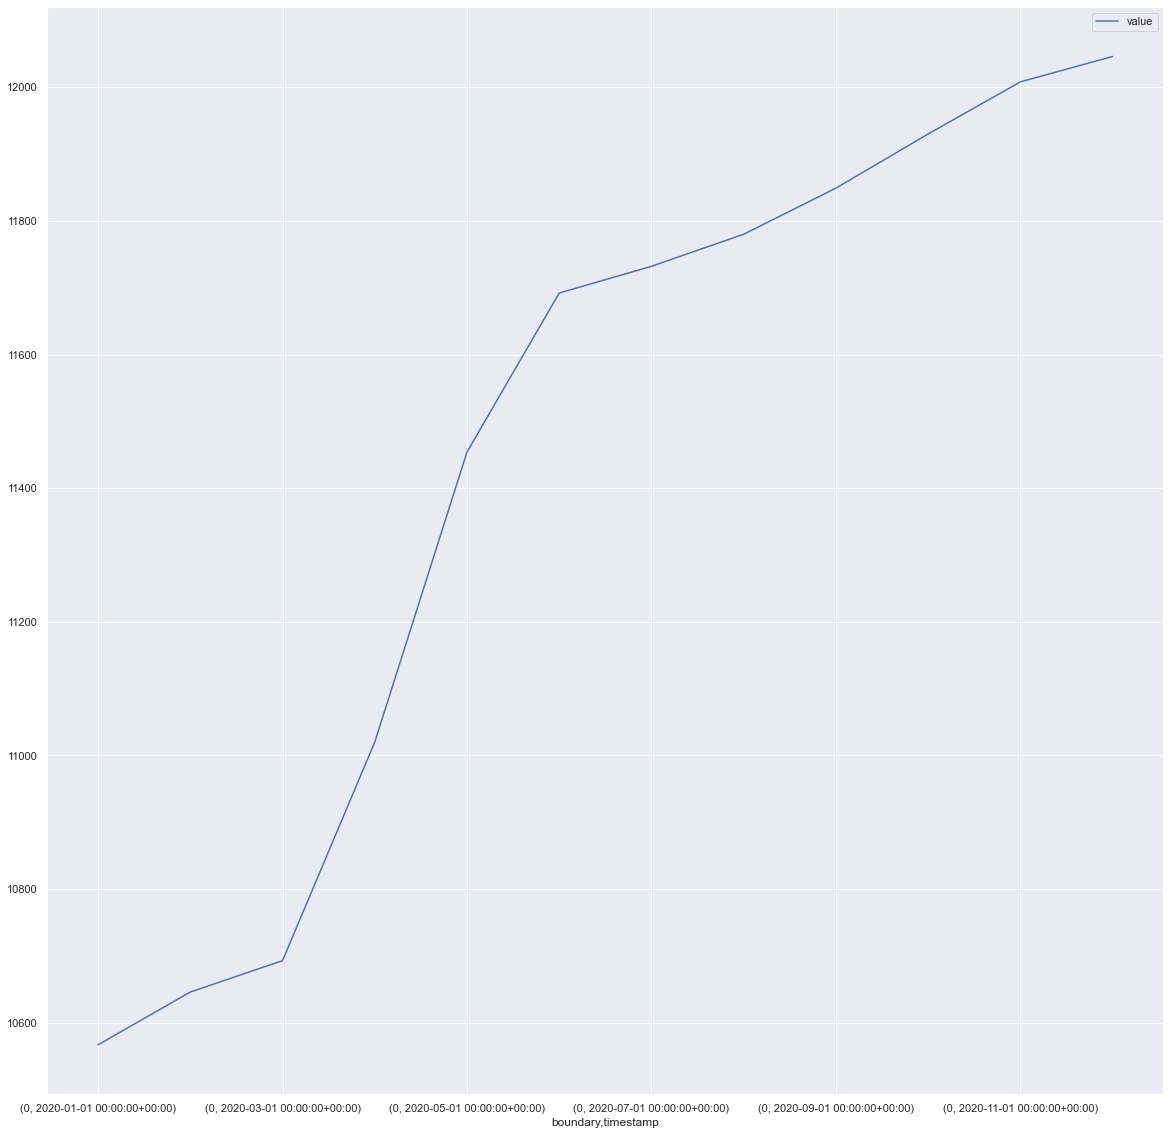

In [19]:
pharmacy_df.plot(figsize=(20,20))
plt.show()

In [20]:
pharmacy_df.to_csv("phamarcies_in_italy.csv")

# tag covid
*:covid19=*

In [21]:
time = "2020-01-01/2020-12-31/P1M"
flter = "delivery:covid19=* or opening_hours:covid19=* or description:covid19=* or takeaway:covid19=* or access:covid19=*" 

In [22]:
covid_delivery = client.elements.count.groupByBoundary.post(bpolys=italy_borders, filter="delivery:covid19=*",time=time)

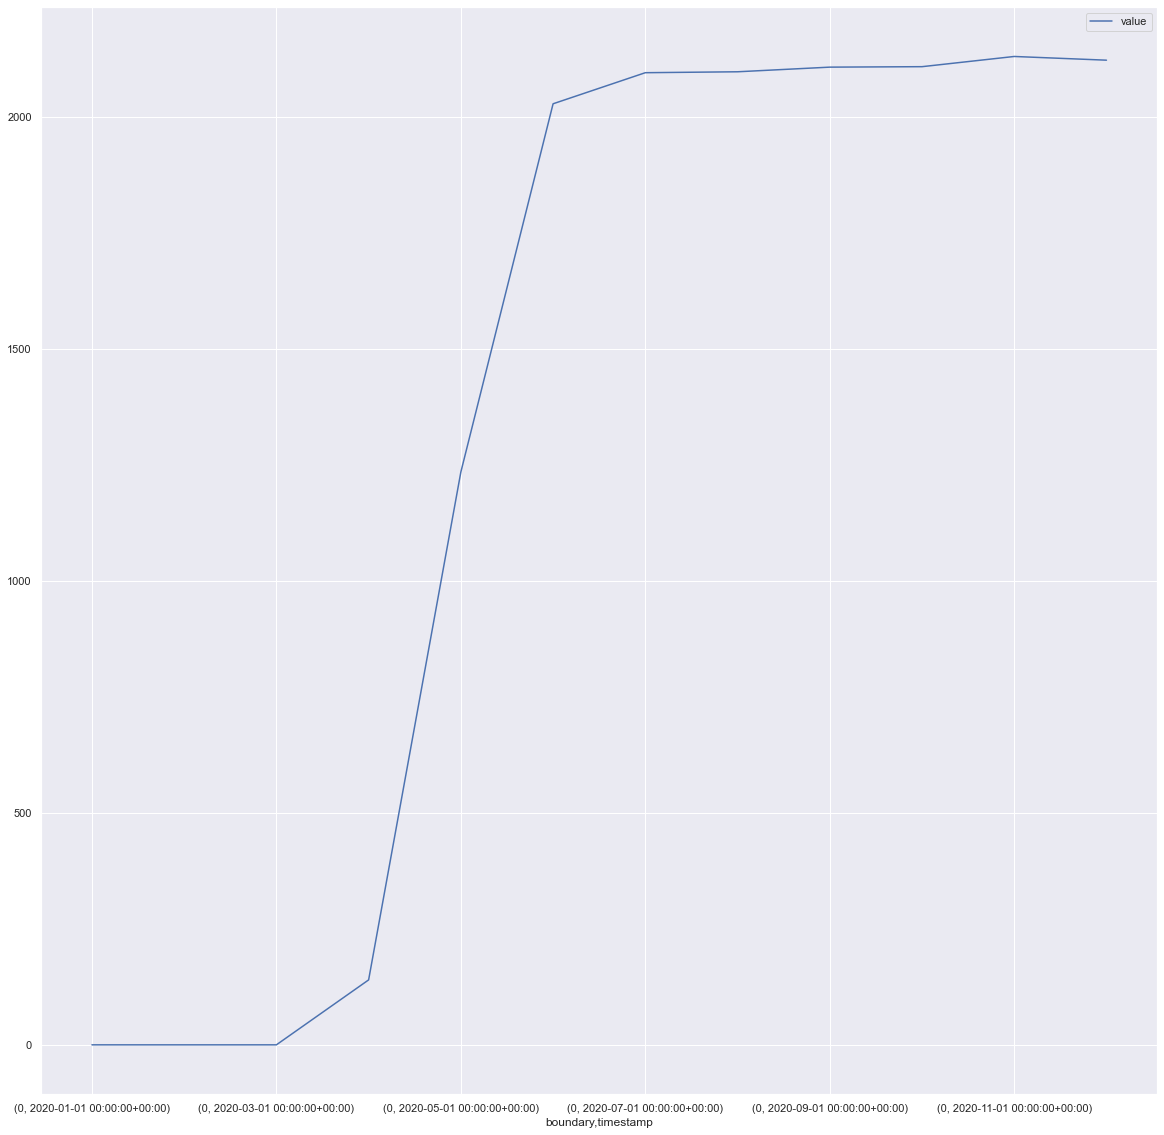

In [23]:
covid_delivery.as_dataframe().plot(figsize=(20,20))
plt.show()

### Codogno Users pro week

In [24]:
bboxes = codogno
time = "2020-02-01/2020-06-30/P1W"
total_users_codogno = client.post(bboxes=bboxes, time=time,endpoint="/users/count")

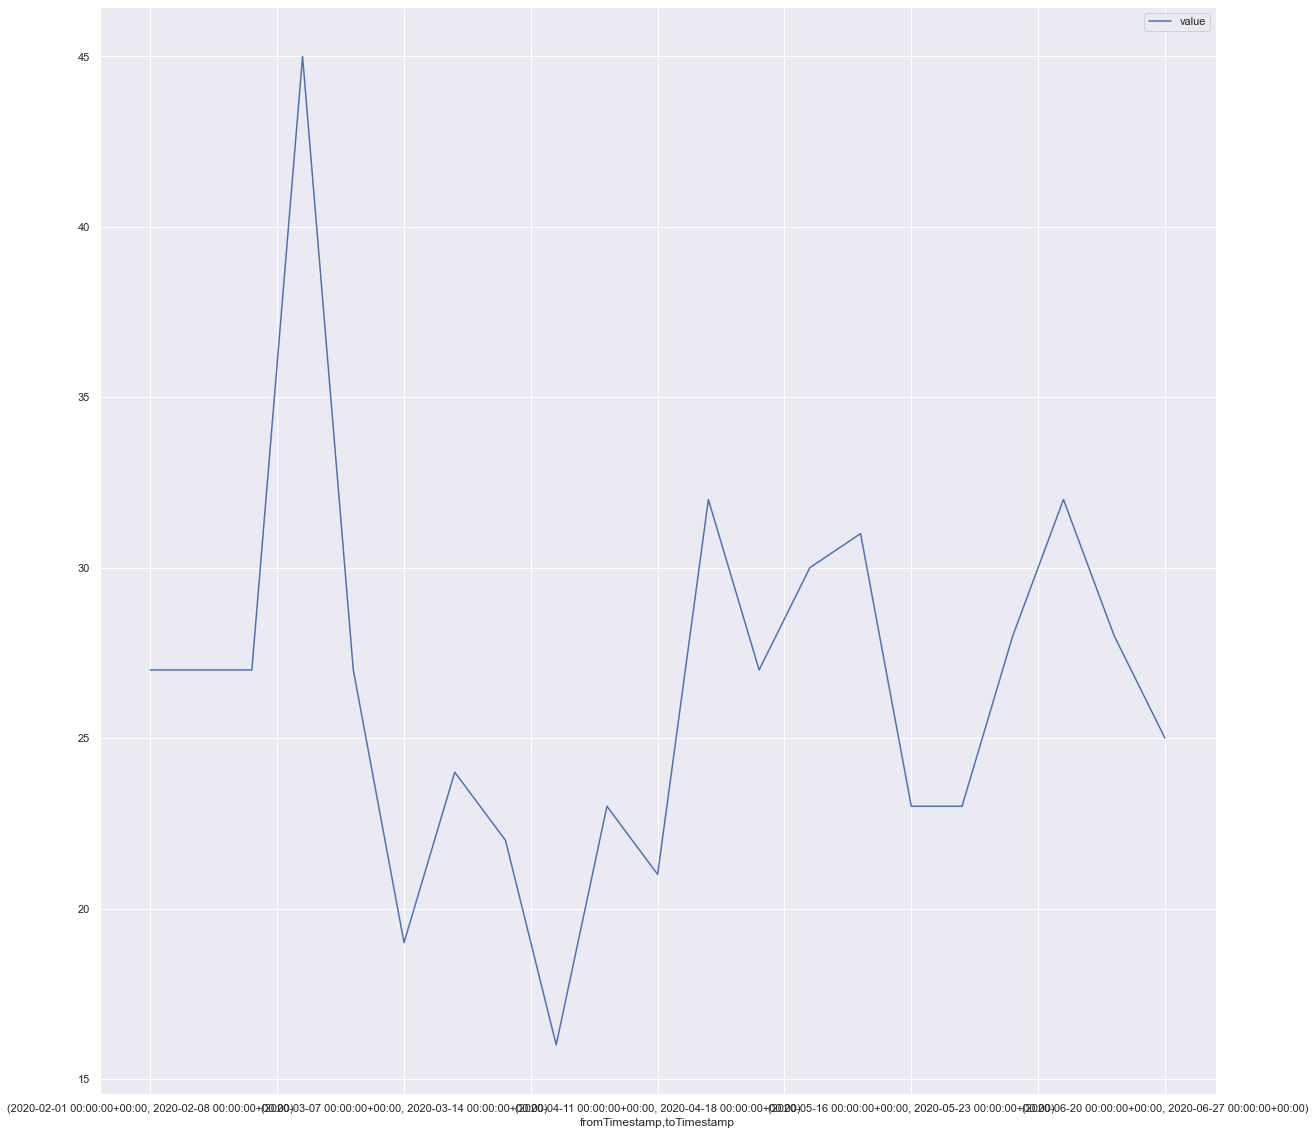

In [25]:
total_users_codogno.as_dataframe().plot(figsize=(20,20))
plt.show()

In [26]:
total_users_codogno.as_dataframe().to_csv("total_users.codogno.csv")

In [28]:
time = "2020-01-01/2020-12-31/P1W"
contributions_codogno = client.post(bboxes=bboxes, time=time,endpoint="contributions/count",showMetadata=True,timeout=600)

OhsomeException: OhsomeException (413): The given query is too large in respect to the given timeout. Please use a smaller region and/or coarser time period.

In [ ]:
contributions_codogno.as_dataframe().plot(figsize=(20,20))

In [ ]:
contributions_codogno.as_dataframe().to_csv("contributions_codogno.csv")

In [30]:
response = client.elements.geometry.post(bpolys=bpolys, filter="amenity=pharmacy",
					 time="2020-01-01",
					 properties="tags")
response_gdf = response.as_geodataframe()

<AxesSubplot:>

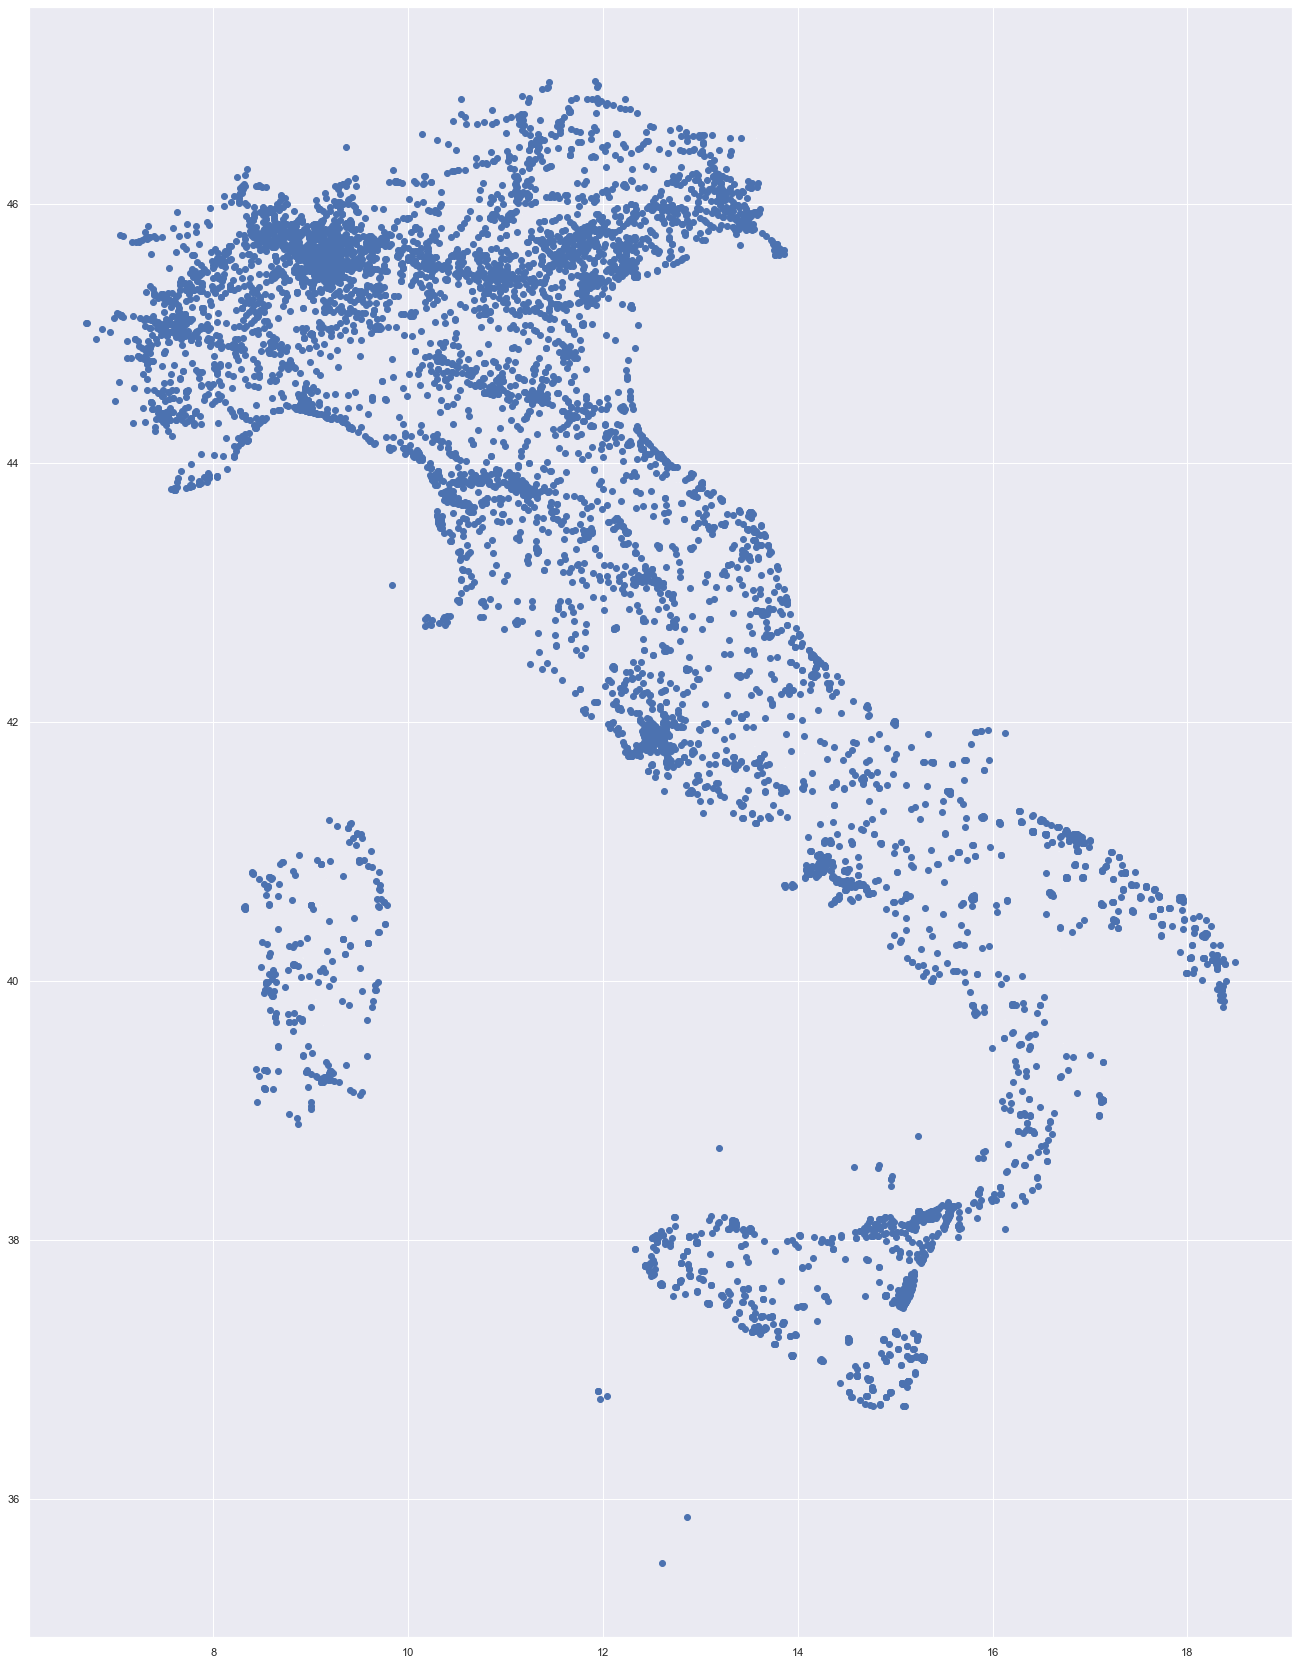

In [32]:
response_gdf.plot(figsize=(30,30))
plt.plot()

In [33]:
e = client.elements.geometry.post(bpolys=bpolys, filter="amenity=pharmacy",
					 time="2020-12-31",
					 properties="tags")
response_gdf = response.as_geodataframe()

[]

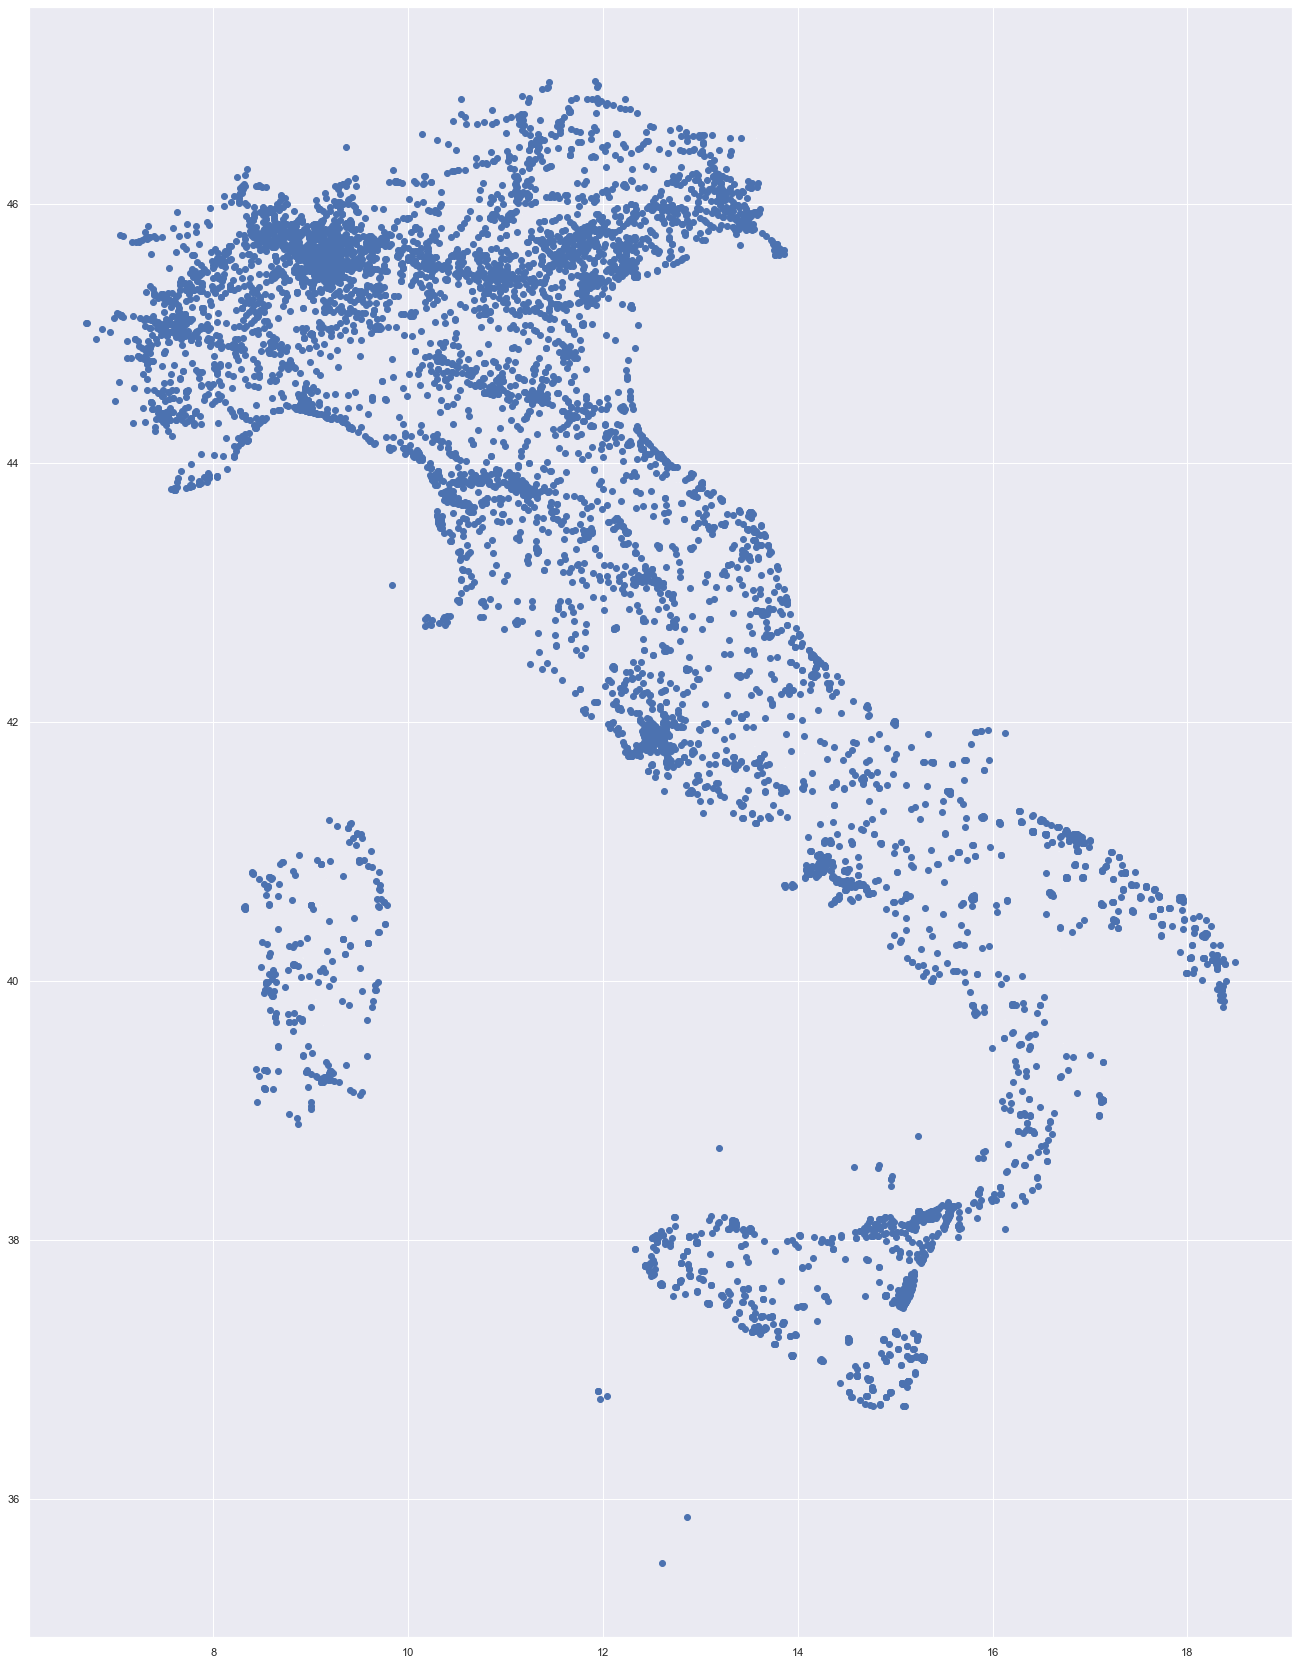

In [34]:
response_gdf.plot(figsize=(30,30))
plt.plot()